In [2]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt


The following command must be run outside of the IPython shell:

    $ pip install yfinance

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [6]:
# Månadskostnad, Timpris, sek/km
small = [0, 110, 2]
medium = [195, 85, 2]
large = [895, 60, 2]
subscriptions = np.array([small, medium, large])

                    S               M               L
count  1000000.000000  1000000.000000  1000000.000000
mean     36436.905079    29884.819628    23837.734178
std      15786.277122    12589.048257     9407.420154
min          4.249810      198.432739      897.615668
25%      25003.194622    20794.437698    17082.270992
50%      34848.322050    28665.648695    22989.038423
75%      46144.401651    37660.068319    29689.399553
max     130517.450958   104012.364652    78012.278347


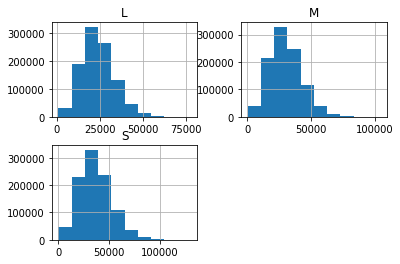

In [184]:
# Sample variabler
# 1. Antalet hyrningar
# 2. Antalet timmar bilen hyrs
# 3. Timmar/hyra

N = 1*10**6
muHoursRents = 6
muKmRents = 75
muRents = 45
sigmaHoursRents = 2
sigmaKmRents = 5
sigmaRents = 15
mus = [muRents, muHoursRents, muKmRents]
sigmas = [sigmaRents, sigmaHoursRents, sigmaKmRents]

lower = 0

dists = []
for mu, sigma in zip(mus, sigmas):
    dists.append(truncnorm.rvs((lower-mu)/sigma, (mu)/sigma, loc = mu, scale = sigma, size = N))

priceDists = []
for sub in subscriptions:
    X = sub[0] + dists[0] * (dists[2] * sub[2] + dists[1] * sub[1])
    X = X.reshape(-1, 1)
    priceDists.append(X)

dfPriceDists = pd.DataFrame(np.concatenate(priceDists, axis = 1), columns = ['S', 'M', 'L'])

print(dfPriceDists.describe())
dfPriceDists.hist()
plt.show()

In [185]:
maxValue = max(np.concatenate(priceDists, axis = 0)) + 10000
cuts = np.arange(0, np.round(maxValue, -3), 10000)

dfFrequencies = dfPriceDists.melt()
dfFrequencies['bins'] = pd.cut(dfFrequencies['value'], cuts)

def percent(row):
    groupCount = row['value'].sum()
    row['dist'] = row['value']/groupCount
    return row

dfPercent = dfFrequencies.groupby(['variable', 'bins']).count().reset_index().dropna().groupby(['variable']).apply(percent)
dfPercent['cumsum'] = dfPercent.groupby('variable')['value'].cumsum()
dfPercent['binRight < X'] = dfPercent['value'] / dfPercent['cumsum']
dfPercent['binRight > X'] = 1 - dfPercent['binRight < X']
dfPercent.columns = ['subscription', 'bins', 'frequencies', 'binLeft < X <= binRight', 'cumsumCount', 'binRight < X', 'binRight > X']
dfFrequencies = pd.pivot_table(dfPercent[['subscription', 'bins', 'binLeft < X <= binRight', 'binRight < X', 'binRight > X']], values = ['binLeft < X <= binRight', 'binRight < X', 'binRight > X'], index = ['bins'], columns = ['subscription'])
dfFrequencies

binLeft < X <= binRight                     binRight < X  \
subscription                               L         M         S            L   
bins                                                                            
(0.0, 10000.0]                      0.051409  0.034827  0.023518     1.000000   
(10000.0, 20000.0]                  0.318920  0.192178  0.120615     0.861180   
(20000.0, 30000.0]                  0.388854  0.315090  0.230312     0.512201   
(30000.0, 40000.0]                  0.184729  0.256560  0.250309     0.195706   
(40000.0, 50000.0]                  0.047778  0.133062  0.187316     0.048178   
(50000.0, 60000.0]                  0.007585  0.049997  0.107617     0.007591   
(60000.0, 70000.0]                  0.000693  0.014440  0.050620     0.000693   
(70000.0, 80000.0]                  0.000032  0.003257  0.020296     0.000032   
(80000.0, 90000.0]                       NaN  0.000520  0.006820          NaN   
(90000.0, 100000.0]                      NaN  0.000067  0.002016          NaN   
(100000.0, 110000.0]                     NaN  0.000002  0.000465          NaN   
(110000.0, 120000.0]                     NaN       NaN  0.000085          NaN   
(120000.0, 130000.0]                     NaN       NaN  0.000010          NaN   
(130000.0, 140000.0]                     NaN       NaN  0.000001          NaN   

                                         binRight > X                      
subscription                 M         S            L         M         S  
bins                                                                       
(0.0, 10000.0]        1.000000  1.000000     0.000000  0.000000  0.000000  
(10000.0, 20000.0]    0.846580  0.836831     0.138820  0.153420  0.163169  
(20000.0, 30000.0]    0.581245  0.615076     0.487799  0.418755  0.384924  
(30000.0, 40000.0]    0.321240  0.400652     0.804294  0.678760  0.599348  
(40000.0, 50000.0]    0.142814  0.230665     0.951822  0.857186  0.769335  
(50000.0, 60000.0]    0.050928  0.117015     0.992409  0.949072  0.882985  
(60000.0, 70000.0]    0.014496  0.052169     0.999307  0.985504  0.947831  
(70000.0, 80000.0]    0.003259  0.020489     0.999968  0.996741  0.979511  
(80000.0, 90000.0]    0.000520  0.006838          NaN  0.999480  0.993162  
(90000.0, 100000.0]   0.000067  0.002017          NaN  0.999933  0.997983  
(100000.0, 110000.0]  0.000002  0.000465          NaN  0.999998  0.999535  
(110000.0, 120000.0]       NaN  0.000085          NaN       NaN  0.999915  
(120000.0, 130000.0]       NaN  0.000010          NaN       NaN  0.999990  
(130000.0, 140000.0]       NaN  0.000001          NaN       NaN  0.999999

In [232]:
# Sample variabler
# 1. Antalet hyrningar
# 2. Antalet timmar bilen hyrs
# 3. Timmar/hyra

N = 1*10**6
muHoursRents = 6
muKmRents = 75
muRents = 45
sigmaHoursRents = 2
sigmaKmRents = 5
sigmaRents = 15

lower = 0

test = []
for x in range(0, 3):
    test.append(truncnorm.rvs((lower-muRents)/sigmaRents, (muRents)/sigmaRents, loc = muRents, scale = sigmaRents, size = N))


# # numberOfRents = np.random.normal(muRents, sigmaRents, N)
# numberOfRents = truncnorm.rvs((lower-muRents)/sigmaRents, (muRents)/sigmaRents, loc = muRents, scale = sigmaRents, size = N)

# hoursRent = np.random.normal(muHoursRents, sigmaHoursRents, N)
# # hoursRent = truncnorm.rvs((lower-muHoursRents)/sigmaHoursRents, (muHoursRents)/sigmaHoursRents, loc = muRents, scale = sigmaRents, size = N)

# kmRents = np.random.normal(muKmRents, sigmaKmRents, N)

# fig = plt.figure(figsize = (20,10))

# ax = fig.add_subplot(221)
# ax.hist(hoursRent, bins = 50)
# ax.axvline(hoursRent.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
# ax.text(hoursRent.mean()*1.1, max_ylim*1, 'Mean: {:.2f}'.format(hoursRent.mean()))

# ax1 = fig.add_subplot(222)
# ax1.hist(kmRents, bins = 50)
# ax1.axvline(kmRents.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
# ax1.text(kmRents.mean()*1.1, max_ylim*1, 'Mean: {:.2f}'.format(kmRents.mean()))


# ax2 = fig.add_subplot(223)
# ax2.hist(numberOfRents, bins = 50)
# ax2.axvline(numberOfRents.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
# ax2.text(numberOfRents.mean()*1.1, max_ylim*1, 'Mean: {:.2f}'.format(numberOfRents.mean()))


[array([22.94969854, 14.62912244, 31.6256654 , ..., 42.90651963,
        42.47764646, 44.89356167]),
 array([39.57021018, 33.39326065, 67.65211215, ..., 17.55218259,
        24.7298153 , 25.04490405]),
 array([18.84342087, 36.85389069, 37.85478417, ..., 39.79503576,
        57.38935029, 38.62388324])]

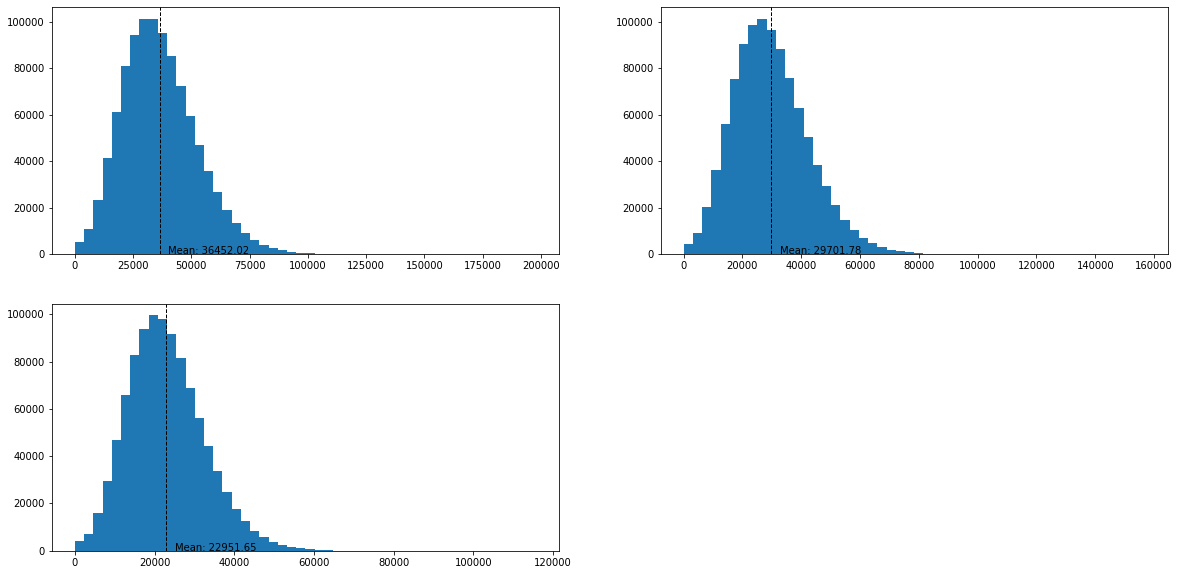

array([24946.30882682, 34867.02297394, 46229.97986081])

In [165]:
distSmall = numberOfRents * (kmRents * small[2] + hoursRent * small[1])
distMedium = numberOfRents * (kmRents * medium[2] + hoursRent * medium[1])
distLarge = numberOfRents * (kmRents * large[2] + hoursRent * large[1])

distSmall = np.clip(distSmall, 0, max(distSmall))
distMedium = np.clip(distMedium, 0, max(distMedium))
distLarge = np.clip(distLarge, 0, max(distLarge))


fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(221)
ax.hist(distSmall, bins = 50)
ax.axvline(distSmall.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
ax.text(distSmall.mean()*1.1, max_ylim*1, 'Mean: {:.2f}'.format(distSmall.mean()))

ax1 = fig.add_subplot(222)
ax1.hist(distMedium, bins = 50)
ax1.axvline(distMedium.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
ax1.text(distMedium.mean()*1.1, max_ylim*1, 'Mean: {:.2f}'.format(distMedium.mean()))

ax2 = fig.add_subplot(223)
ax2.hist(distLarge, bins = 50)
ax2.axvline(distLarge.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
ax2.text(distLarge.mean()*1.1, max_ylim*1, 'Mean: {:.2f}'.format(distLarge.mean()))

np.quantile(distSmall, [0.25, 0.5, 0.75])

In [210]:
distSmall = distSmall.reshape(-1, 1)
distMedium = distMedium.reshape(-1, 1)
distLarge = distLarge.reshape(-1, 1)
X = np.concatenate((np.sort(distSmall, axis = 0), np.sort(distMedium, axis = 0), np.sort(distLarge, axis = 0)), axis = 1)
df = pd.DataFrame(X, columns = ['small', 'medium', 'large'])
df = df.melt()
dfStats = df.groupby('variable').describe().T
print(dfStats)

# cuts = np.linspace(0, np.round(max(df.value), -3), 10).flatten()
cuts = np.arange(0, np.round(max(df.value), -3), 10000)

df['bins'] = pd.cut(df['value'], cuts)
df = df.dropna()

def percent(row):
    groupCount = row['value'].sum()
    row['dist'] = row['value']/groupCount
    return row

dfFrequencies = df.groupby(['variable', 'bins']).count().reset_index().dropna().groupby(['variable']).apply(percent)
# dfFrequencies['dist'] = pd.Series(["{0:.2f}%".format(val * 100) for val in dfFrequencies['dist']], index = dfFrequencies.index)
dfFrequencies = pd.pivot_table(dfFrequencies[['variable', 'dist', 'value', 'bins']], values = ['dist', 'value'], index = ['bins'], columns = ['variable'])
print(dfFrequencies)


variable              large          medium           small
value count  1000000.000000  1000000.000000  1000000.000000
      mean     22951.654961    29701.783241    36452.021237
      std       9534.419924    12760.973690    16003.110584
      min          0.000000        0.000000        0.000000
      25%      16152.598843    20550.999608    24946.308827
      50%      22106.658030    28484.948096    34867.022974
      75%      28839.258011    37527.953908    46229.979861
      max     115730.887889   156856.559971   197982.232052


                          dist                         value            \
variable                 large    medium     small     large    medium   
bins                                                                     
(0.0, 10000.0]        0.068277  0.038083  0.024851   68185.0   38030.0   
(10000.0, 20000.0]    0.340367  0.194743  0.119582  339910.0  194474.0   
(20000.0, 30000.0]    0.374249  0.313688  0.229355  373746.0  313254.0   
(30000.0, 40000.0]    0.167691  0.253967  0.249166  167466.0  253616.0   
(40000.0, 50000.0]    0.041569  0.131293  0.187265   41513.0  131112.0   
(50000.0, 60000.0]    0.006967  0.049241  0.108011    6958.0   49173.0   
(60000.0, 70000.0]    0.000788  0.014500  0.050924     787.0   14480.0   
(70000.0, 80000.0]    0.000084  0.003608  0.020349      84.0    3603.0   
(80000.0, 90000.0]    0.000006  0.000702  0.007244       6.0     701.0   
(90000.0, 100000.0]        NaN  0.000145  0.002370       NaN     145.0   
(100000.0, 110000.0]       NaN  0.0000

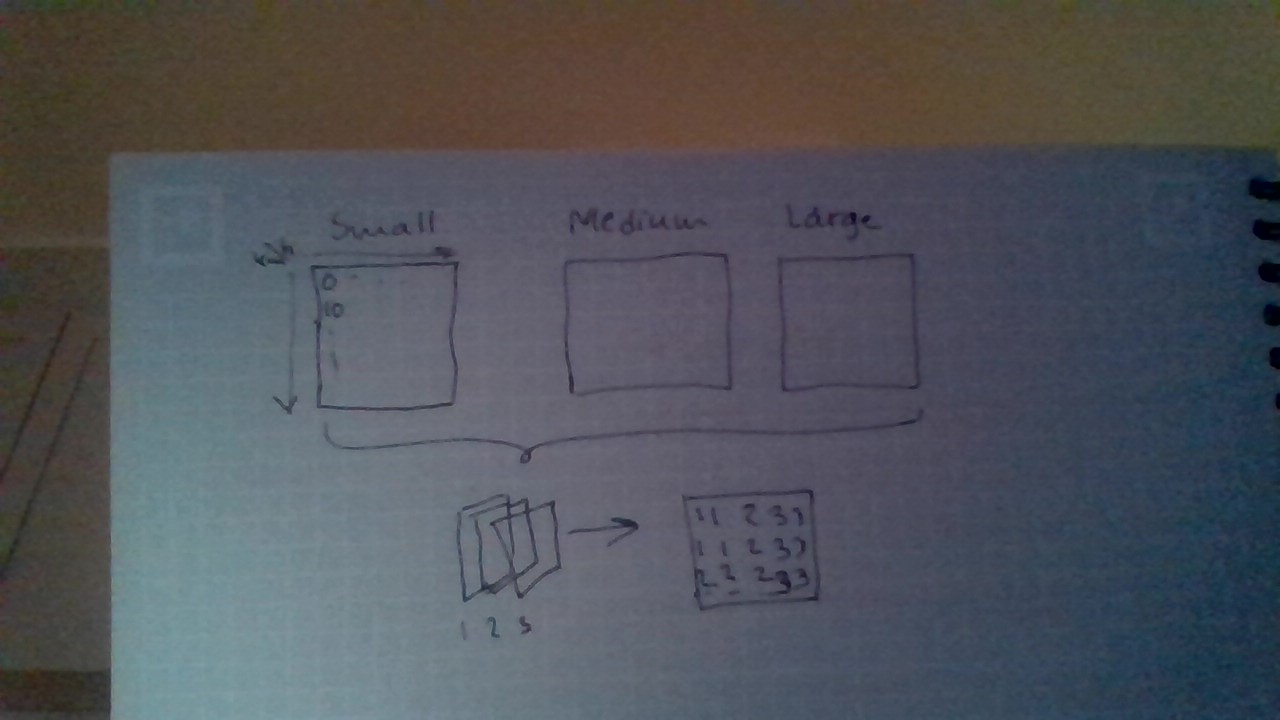

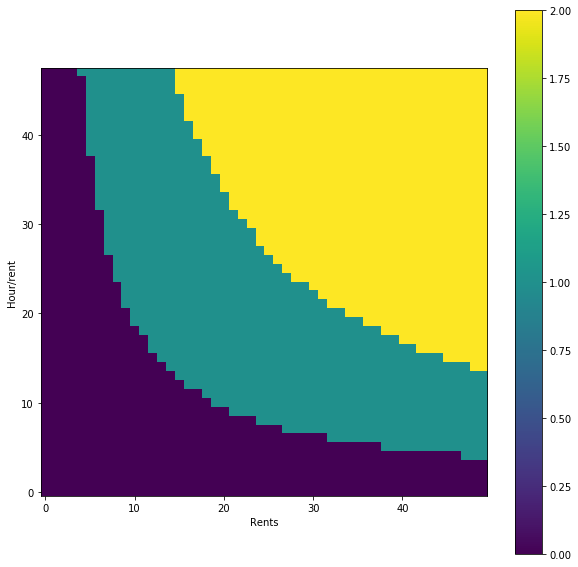

(48, 50, 3)

In [198]:
hrs = np.linspace(0,24)
rents = np.linspace(0,48,num=48)
hrRents = np.meshgrid(hrs,rents)
hrRents = np.moveaxis(np.array(hrRents),0,-1)
sekKm = 2
kmPerRent = 20
monthlyCost = np.array([0,195,895])
hourlyCost = np.array([110,85,60]).reshape(1,-1)

costAllSer = 12*monthlyCost+hrRents[...,1:2]*(hrRents[...,0:1]*hourlyCost)

plt.figure(figsize=(10,10))
plt.imshow(np.argmin(costAllSer,axis= -1),origin='Lower')
plt.xlabel('Rents')
plt.ylabel('Hour/rent')
plt.colorbar()
costAllSer.shape

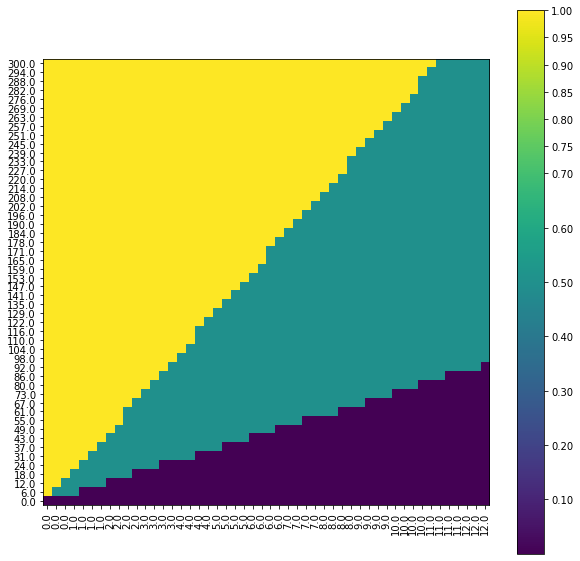

In [254]:
mnths = np.linspace(0, 12)
hRents = np.linspace(0, 300)
hrRents = np.meshgrid(mnths, hRents)
hrRents = np.moveaxis(np.array(hrRents),0,-1)

monthlyCost = np.array([0,195,895]).reshape(1, -1)
hourlyCost = np.array([110,85,60]).reshape(1,-1)

costAllSer = (hrRents[...,0:1]*monthlyCost) + (hrRents[...,1:2]*hourlyCost)

# plt.figure(figsize=(10,10))
# plt.imshow(np.argmin(costAllSer,axis= -1),origin='Lower')#, extent = [0, 12, 0, 300])
# plt.xlabel('Months')
# plt.ylabel('Hours')
# plt.colorbar()

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(np.argmin(costAllSer,axis= -1),origin='Lower')#,
#cax = ax.matshow(costAllSer, interpolation='nearest')
#ax.grid(True)
# plt.title('San Francisco Similarity matrix')
plt.xticks(range(50), np.round(mnths,0), rotation=90);
plt.yticks(range(50), np.round(hRents,0+));
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()
